In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm
import PIL
import torchvision.transforms.functional as TF
from IPython.display import display
import ipywidgets as widgets
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [4]:
device = torch.device("cuda")

In [23]:
def image_shower(images, labels, n=4):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 12)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1,2,0)).squeeze())
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))

classes = ("FAKE", "REAL")
PATH = "content\dataset\generated"

def select_file():
    fc = widgets.FileUpload()
    display(fc)
    return fc.value


In [26]:
transform = transforms.Compose(
    [   transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
)

# 1 -> 1
# 0 -> -1

# trainset = torchvision.datasets.ImageFolder(os.path.join(PATH, "train"), transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=0, shuffle=True)

# testset = torchvision.datasets.ImageFolder(os.path.join(PATH, "test"), transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, num_workers=0, shuffle=True)

mytestset = torchvision.datasets.ImageFolder(r"C:\Users\Danila\VSU\vsu_common_rep\vsu_common_rep\2year\2term\project\image_classification\content\CNN_synth\validation\test_model", transform=transform)
mytestloader = torch.utils.data.DataLoader(mytestset, batch_size=64, num_workers=0, shuffle=True)

In [12]:
model = torchvision.models.resnet18(weights=torchvision.models.quantization.ResNet18_QuantizedWeights)
for param in model.parameters():
    param.required_grad = False
model.fc = nn.Linear(512, 2)

C:\Users\Danila\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [7]:
epochs = 6
model.to(device)
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader)):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print("Epoch {} - Training loss: {}".format(epoch, running_loss/len(trainloader)))
    #1 - 0.15686891703989764
    #2 - 0.10915772606495361
    #3 ~ 0.07
    #4 ~ 0.05
    #5 - 0.0421017769123657
    #6 - 0.03336860248994771
    #7 - 0.028021059657497092
    #8 - 0.022824570378683753
    

1563it [15:07,  1.72it/s]


Epoch 0 - Training loss: 0.3879337168452988


1563it [10:13,  2.55it/s]


Epoch 1 - Training loss: 0.17330395480259175


1563it [04:25,  5.89it/s]


Epoch 2 - Training loss: 0.08995118404792828


1563it [04:30,  5.78it/s]


Epoch 3 - Training loss: 0.0485974382844492


1563it [04:07,  6.31it/s]


Epoch 4 - Training loss: 0.030471268251828162


1563it [04:45,  5.48it/s]

Epoch 5 - Training loss: 0.02096023117023388


In [17]:
device = torch.device("cpu")

In [33]:
# Accuracy calculation
correct = 0
total = 0 
with torch.no_grad():
    model.eval()
    for data in mytestloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        # print(outputs[:, 1].cpu().numpy())
        # print(labels.cpu().numpy())
        # print("--+--")
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print("Accuracy %d" %(100 * correct/total))

Accuracy 48


Real Labels:   FAKE  REAL  REAL  REAL
Predicted:   FAKE  FAKE  FAKE  FAKE


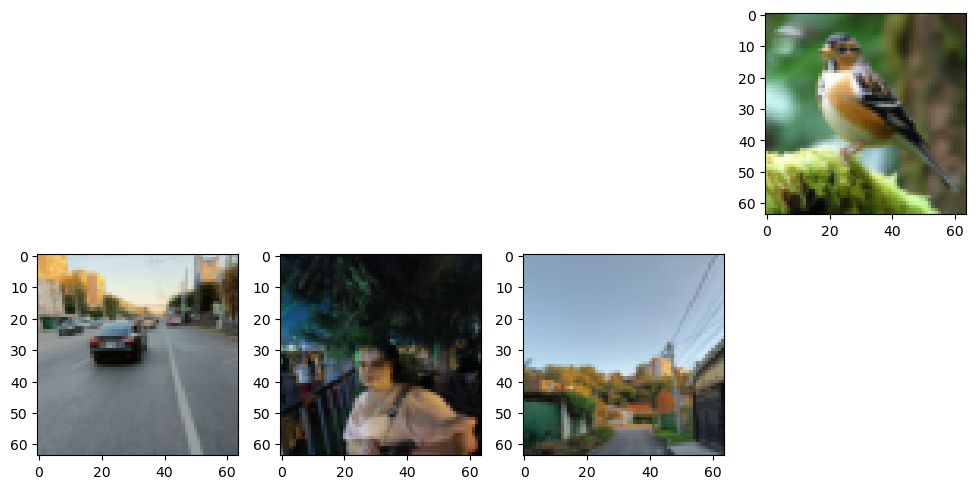

In [29]:
images, labels = next(iter(mytestloader))
image_shower(images, labels)
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)
print("Predicted: ", " ".join("%5s" %classes [predict] for predict in predicted[:4]))

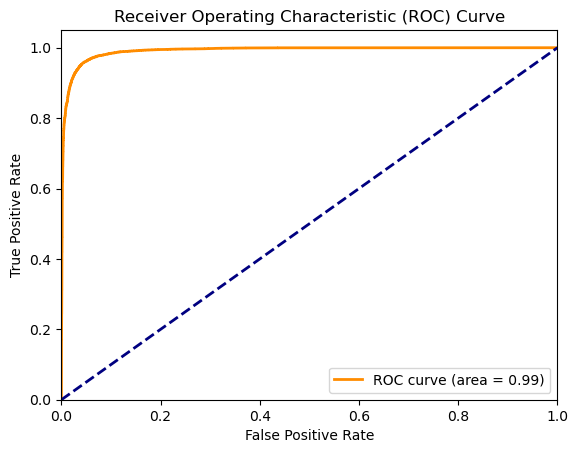

In [15]:
# AUC ROC calculation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

model.eval()

# Lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Iterate over test dataset to obtain true labels and predicted probabilities
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        predicted_probs.extend(outputs[:, 1].cpu().numpy())  # Assuming positive class probabilities are in the second column
        true_labels.extend(labels.cpu().numpy())

# Calculate ROC curve
fpr, tpr, _ = roc_curve(true_labels, predicted_probs)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [77]:
img = select_file()

FileUpload(value={}, description='Upload')

In [22]:
img = torchvision.io.read_image("test.jpg")
img = torchvision.transforms.functional.to_pil_image(img)
t = transform(img)
t = t.unsqueeze(0)
print(t.shape)
model.eval()
output = model(t)
_, pred = torch.max(output.data, 1)

torch.Size([1, 3, 64, 64])


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [19]:
print(pred)

NameError: name 'pred' is not defined

In [86]:
a = torch.randn(4, 4)
print(a)
print(torch.max(a))

tensor([[ 0.2261,  0.2764, -0.7918, -0.4156],
        [ 1.1383, -2.5703,  1.5196,  0.6766],
        [-0.0727,  0.6674,  0.7022,  0.5263],
        [-0.3587,  0.0922, -0.1311, -0.2156]])
tensor(1.5196)


In [13]:
# Saving model
torch.save(model.state_dict(), 'face_categorization_6_epoch.pth')

In [32]:
# Loading model 
model.load_state_dict(torch.load('models/im_cl(7).pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  